## House Price Prediction Challenge

https://www.kaggle.com/datasets/anmolkumar/house-price-prediction-challenge

Необходимо предсказать цены домов в Индии. 

Целевая переменная TARGET(PRICE_IN_LACS).


---



POSTED_BY - Категория, обозначающая, кто внес недвижимость в список (собственник или дилер)

UNDER_CONSTRUCTION - Строится или нет

RERA - одобрено ли агрегатором ReRa

BHK_NO - Количество комнат

BHK_OR_RK - Тип недвижимости

SQUARE_FT - Общая площадь дома в квадратных футах

READY_TO_MOVE - Готовность к заселению

RESALE - Вторичное или первичное жильё

ADDRESS - Адрес объекта недвижимости

LONGITUDE - Долгота объекта недвижимости

LATITUDE - Широта объекта недвижимости

0 - нет, 1 - да

PRICE_IN_LACS - цена дома в лакхах. В Индии 150 000 рупий становятся 1,5 лакха рупий

Выделяют следующие типы регрессионного анализа: Линейная регрессия (Linear Regression) Полиномиальная регрессия (Polynomial Regression) Регрессия опорных векторов (SVR) Регрессия Дерева решений (Decision Tree) Регрессия Случайного леса (Random Forest). Линейная регрессия.

# Установка пакетов

In [1]:
!pip install --upgrade matplotlib > None
!pip install basemap > None
!pip install optuna > None
!pip install catboost > None

In [2]:
pip install category_encoders --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [98]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from catboost import Pool, cv
from catboost import Pool, cv

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from mpl_toolkits.basemap import Basemap
import plotly.express as px
from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.dummy import DummyRegressor 
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras


from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
from collections import Counter
import optuna

%matplotlib inline

# Обзор данных и их предобработка

##Основная информация

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Uberwald/Junior-ML-contest/main/Source/train.csv')

In [5]:
df.shape

(29451, 12)

In [6]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


В этом датасете перепутаны широта и долгота. Поменяем названия столбцов

In [7]:
df.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

In [8]:
df.rename(columns={'LONGITUDE': 'LATITUDE', 'LATITUDE': 'LONGITUDE', 'BHK_NO.':'BHK_NO'}, inplace=True)

In [9]:
df.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO,SQUARE_FT,READY_TO_MOVE,RESALE,LATITUDE,LONGITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


Поразбираем **describe()**.
Известно: Индия расположена к северу от экватора между 6°44' и 35°30' северной широты и 68°7' и 97°25' восточной долготы.
Мы видим, что в широте есть выбор -121.76 еще и 152.96. *Нужно будет поработать над выбросами.*

###Сразу же удалим координаты, не относящиеся к Индии

ВНИМАНИЕ!

Используемый метод для расчётов координат занял очень много времени, поэтому, во избежания долгой загрузки при запуске блокнота, удаление координат мест вне Индии было проведено заранее и результаты загружены на GutHub. 

[Ссылка на обработанный файл](https://raw.githubusercontent.com/Uberwald/ML-in-science/main/save_all_countries.csv)

С помощью библиотеки geopy можно определить адрес по координатам. Как было указано выше, часть координат не соответствует адресам, поэтому мы удалим строки с такими ошибками. Сначала мы соединим ячейки LATITUDE и LONGITUDE, чтобы их мог переварить geopy, после этого мы извлечём из строк с адресом страну, а после мы удалим строки, которые не отностся к Индии

In [10]:
# !pip install geopy

In [11]:
# #Сделаем копию датасета для первой обработки
# df_India = df.copy()

In [12]:
# coord = []
# for i in range(len(df_India)):
#   x = eval(np.array2string(df_India['LATITUDE'][i].astype('str')))
#   y = eval(np.array2string(df_India['LONGITUDE'][i].astype('str')))
#   z = x + ', ' + y
#   coord.append(z)

In [13]:
# from geopy.geocoders import Nominatim
# import time
# geolocator = Nominatim(user_agent="Your_app-name")

### Разделение данных на батчи и удаление из них лишних координат

Так как код для 29451 строки исполняется два часа и в итоге выдает ошибку из-за слишком большого количества обращений на сервер, было принято решение выполнить вычисления, разбив выборку на части по 1000 строк.

In [14]:
# batch1 = coord[0:2000]
# batch2 = coord[2000:4000]
# batch3 = coord[4000:6000]
# batch4 = coord[6000:8000]
# batch5 = coord[8000:10000]
# batch6 = coord[10000:12000]
# batch7 = coord[12000:14000]
# batch8 = coord[14000:16000]
# batch9 = coord[16000:18000]
# batch10 = coord[18000:20000]
# batch11 = coord[20000:22000]
# batch12 = coord[22000:24000]
# batch13 = coord[24000:26000]
# batch14 = coord[26000:28000]
# batch15 = coord[28000:29451]

In [15]:
#Проверим размерность полученных батчей
# fffasd = batch1+batch2 +batch3 +batch4 +batch5 +batch6 +batch7 +batch8 +batch9 +batch10+batch11+batch12+batch13 +batch14 +batch15
# len(fffasd)

In [16]:
# batch2[0]

###### batch1

In [17]:
# country1 = []
# start_time = time.time()
# for i in range(len(batch1)):
#   location = geolocator.reverse(batch1[i])
#   try:
#     loc_add = location.address
#     country1.append(loc_add.split()[-1])
#   except:
#     country1.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [18]:
# print(*set(country1))
# print(len(country1))
# Counter(country1).values()

###### batch2

In [19]:
# country2 = []
# start_time = time.time()
# for i in range(len(batch2)):
#   location = geolocator.reverse(batch2[i])
#   try:
#     loc_add = location.address
#     country2.append(loc_add.split()[-1])
#   except:
#     country2.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# print(*set(country2))
# print(len(country2))
# Counter(country2).values()

###### batch3

In [21]:
# country3 = []
# start_time = time.time()
# for i in range(len(batch3)):
#   location = geolocator.reverse(batch3[i])
#   try:
#     loc_add = location.address
#     country3.append(loc_add.split()[-1])
#   except:
#     country3.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# print(*set(country3))
# print(len(country3))
# Counter(country3).values()

###### batch4

In [23]:
# country4 = []
# start_time = time.time()
# for i in range(len(batch4)):
#   location = geolocator.reverse(batch4[i])
#   try:
#     loc_add = location.address
#     country4.append(loc_add.split()[-1])
#   except:
#     country4.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
# print(*set(country4))
# print(len(country4))
# Counter(country4).values()

###### batch5

In [25]:
# country5 = []
# start_time = time.time()
# for i in range(len(batch5)):
#   location = geolocator.reverse(batch5[i])
#   try:
#     loc_add = location.address
#     country5.append(loc_add.split()[-1])
#   except:
#     country5.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [26]:
# print(*set(country5))
# print(len(country5))
# Counter(country5).values()

###### batch6

In [27]:
# country6 = []
# start_time = time.time()
# for i in range(len(batch6)):
#   location = geolocator.reverse(batch6[i])
#   try:
#     loc_add = location.address
#     country6.append(loc_add.split()[-1])
#   except:
#     country6.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [28]:
# print(*set(country6))
# print(len(country6))
# Counter(country6).values()

###### batch7

In [29]:
# country7 = []
# start_time = time.time()
# for i in range(len(batch7)):
#   location = geolocator.reverse(batch7[i])
#   try:
#     loc_add = location.address
#     country7.append(loc_add.split()[-1])
#   except:
#     country7.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [30]:
# print(*set(country7))
# print(len(country7))
# Counter(country7).values()

###### batch8

In [31]:
# country8 = []
# start_time = time.time()
# for i in range(len(batch8)):
#   location = geolocator.reverse(batch8[i])
#   try:
#     loc_add = location.address
#     country8.append(loc_add.split()[-1])
#   except:
#     country8.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [32]:
# print(*set(country8))
# print(len(country8))
# Counter(country8).values()

###### batch9

In [33]:
# country9 = []
# start_time = time.time()
# for i in range(len(batch9)):
#   location = geolocator.reverse(batch9[i])
#   try:
#     loc_add = location.address
#     country9.append(loc_add.split()[-1])
#   except:
#     country9.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [34]:
# print(*set(country9))
# print(len(country9))
# Counter(country9).values()

###### batch10

In [35]:
# country10 = []
# start_time = time.time()
# for i in range(len(batch10)):
#   location = geolocator.reverse(batch10[i])
#   try:
#     loc_add = location.address
#     country10.append(loc_add.split()[-1])
#   except:
#     country10.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [36]:
# print(*set(country10))
# print(len(country10))
# Counter(country10).values()

###### batch11

In [37]:
# country11 = []
# start_time = time.time()
# for i in range(len(batch11)):
#   location = geolocator.reverse(batch11[i])
#   try:
#     loc_add = location.address
#     country11.append(loc_add.split()[-1])
#   except:
#     country11.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [38]:
# print(*set(country11))
# print(len(country11))
# Counter(country11).values()

###### batch12

In [39]:
# country12 = []
# start_time = time.time()
# for i in range(len(batch12)):
#   location = geolocator.reverse(batch12[i])
#   try:
#     loc_add = location.address
#     country12.append(loc_add.split()[-1])
#   except:
#     country12.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [40]:
# print(*set(country12))
# print(len(country12))
# Counter(country12).values()

###### batch13

In [41]:
# country13 = []
# start_time = time.time()
# for i in range(len(batch13)):
#   location = geolocator.reverse(batch13[i])
#   try:
#     loc_add = location.address
#     country13.append(loc_add.split()[-1])
#   except:
#     country13.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [42]:
# print(*set(country13))
# print(len(country13))
# Counter(country13).values()

###### batch14

In [43]:
# country14 = []
# country14 = []
# start_time = time.time()
# for i in range(len(batch14)):
#   location = geolocator.reverse(batch14[i])
#   try:
#     loc_add = location.address
#     country14.append(loc_add.split()[-1])
#   except:
#     country14.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [44]:
# print(*set(country14))
# print(len(country14))
# Counter(country14).values()

###### batch15

In [45]:
# country15 = []
# start_time = time.time()
# for i in range(len(batch15)):
#   location = geolocator.reverse(batch15[i])
#   try:
#     loc_add = location.address
#     country15.append(loc_add.split()[-1])
#   except:
#     country15.append('NaN')
# print("--- %s seconds ---" % (time.time() - start_time))

In [46]:
# print(*set(country15))
# print(len(country15))
# Counter(country15).values()

In [47]:
# all_countries = country1 + country2 + country3+country4+country5+country6+country7+country8+country9+country10+country11+country12+country13+country14+country15

######SAVE


In [48]:
# #save
# save_all = all_countries
# Z = pd.DataFrame(save_all)
# Z.to_csv('save_all_countries.csv', encoding='utf-8')

In [49]:
countries = pd.read_csv('https://raw.githubusercontent.com/Uberwald/ML-in-science/main/save_all_countries.csv')

#####Немного отредакутируем полученные данные, соединим их с датасетом и удалим всё, что не относится к Индии.

In [50]:
countries = countries.drop(['Unnamed: 0'], axis=1) 

In [51]:
countries = countries.rename(columns = {'0':'Countries'})

In [52]:
#Посмотрим какие же страны у нас затрагивают имеющиеся координаты
countries.value_counts ()

Countries                     
India                             29185
日本                                   73
States                               67
Belgien                              32
Deutschland                          15
ປະເທດລາວ                             15
Canada                                9
Indonesia                             7
नेपाल                                 7
Italia                                7
Ireland                               6
Norge                                 6
Australia                             4
مصر                                   3
Kıbrıs                                2
대한민국                                  2
قطر                                   1
پاکستان                               1
中国                                    1
Andorra                               1
Türkiye                               1
Schweiz/Suisse/Svizzera/Svizra        1
Philippines                           1
Malaysia                              1
Cameroun 

Интересно, что нет ни одного NaN, то есть у нас нет координат нейтральных вод и земель. 

После фильтрации у нас должно остаться не менее 29185 строк

In [53]:
df_new = df.join(countries)

In [54]:
df_new

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LATITUDE,LONGITUDE,TARGET(PRICE_IN_LACS),Countries
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,India
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,India
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,India
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,India
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0,India
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0,States
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1,India
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0,India


In [55]:
df_new = df_new.loc[df_new['Countries'] == 'India']

In [56]:
df_new

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LATITUDE,LONGITUDE,TARGET(PRICE_IN_LACS),Countries
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,India
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,India
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,India
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,India
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29445,Owner,0,0,2,BHK,1062.134891,1,1,"Tilakwadi,Belgaum",15.866670,74.500000,40.0,India
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0,India
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1,India
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0,India


In [57]:
#Убедимся, что все координаты принадлежать Индии
df_new['Countries'].value_counts()

India    29185
Name: Countries, dtype: int64

In [58]:
#Теперь столбец Countries нам не нужен, удалим его
df_new = df_new.drop(['Countries'], axis=1)

In [59]:
df = df_new

##Основная информация продолжение

In [60]:
df.shape

(29185, 12)

In [61]:
# Проверяем количество пропусков
df.isna().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO                   0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LATITUDE                 0
LONGITUDE                0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [62]:
df.dtypes

POSTED_BY                 object
UNDER_CONSTRUCTION         int64
RERA                       int64
BHK_NO                     int64
BHK_OR_RK                 object
SQUARE_FT                float64
READY_TO_MOVE              int64
RESALE                     int64
ADDRESS                   object
LATITUDE                 float64
LONGITUDE                float64
TARGET(PRICE_IN_LACS)    float64
dtype: object

###Предобработка столбцов

Обратим внимание на категориальные столбцы:


*   POSTED_BY                 
*   BHK_OR_RK
*   ADDRESS



In [63]:
df['POSTED_BY'].value_counts()

Dealer     18163
Owner      10407
Builder      615
Name: POSTED_BY, dtype: int64

In [64]:
df['BHK_OR_RK'].value_counts()

BHK    29162
RK        23
Name: BHK_OR_RK, dtype: int64

In [65]:
df['ADDRESS'].value_counts()

Zirakpur,Chandigarh                       509
Whitefield,Bangalore                      230
Raj Nagar Extension,Ghaziabad             215
Sector-137 Noida,Noida                    139
New Town,Kolkata                          131
                                         ... 
haripur phutkuwan Rampur Road,Haldwani      1
Kolshet,Lalitpur                            1
Ambika Township,Jivarajpark,Rajkot          1
Cheranalloor,Kochi                          1
Gandhi Nagar,Gulbarga                       1
Name: ADDRESS, Length: 6804, dtype: int64

In [66]:
df['ADDRESS'].nunique()

6804

Выводы по категориальным столбцам:

*   POSTED_BY - можно закодировать в численные значения и работать дальше 
*   BHK_OR_RK - можно смело удалять, так как параметр имеет всего два значения и разница между ними колоссальна: 99,922% (BHK) и  0,078% (RK)
* ADDRESS - имеет слишком много уникальных значений, к тому же у нас уже есть координаты объектов, поэтому удалим и этот столбец





####Удалим лишние столбцы

In [67]:
# дальше будем работать с df_copy
df_copy = df.copy()

In [68]:
df_copy = df.drop(['BHK_OR_RK', 'ADDRESS'], axis=1)

In [69]:
df_copy.shape

(29185, 10)

####Заменим категориальные данные на численные

Для posted_by и BHK_OR_RK будем использовать one hot encoder, нормализовать эти столбцы не потребуется.

In [70]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols='POSTED_BY',
                         handle_unknown='return_nan',
                         return_df=True,
                         use_cat_names=True)
                         
# преобразование данных
df_copy = encoder.fit_transform(df_copy)
df_copy

,POSTED_BY_Owner,POSTED_BY_Dealer,POSTED_BY_Builder,UNDER_CONSTRUCTION,RERA,BHK_NO,SQUARE_FT,READY_TO_MOVE,RESALE,LATITUDE,LONGITUDE,TARGET(PRICE_IN_LACS)
0,1.0,0.0,0.0,0,0,2,1300.236407,1,1,12.969910,77.597960,55.0
1,0.0,1.0,0.0,0,0,2,1275.000000,1,1,12.274538,76.644605,51.0
2,1.0,0.0,0.0,0,0,2,933.159722,1,1,12.778033,77.632191,43.0
3,1.0,0.0,0.0,0,1,2,929.921143,1,1,28.642300,77.344500,62.5
4,0.0,1.0,0.0,1,0,2,999.009247,0,1,22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29445,1.0,0.0,0.0,0,0,2,1062.134891,1,1,15.866670,74.500000,40.0
29446,1.0,0.0,0.0,0,0,3,2500.000000,1,1,27.140626,78.043277,45.0
29448,0.0,1.0,0.0,0,0,2,1022.641509,1,1,26.928785,75.828002,27.1
29449,1.0,0.0,0.0,0,0,2,927.079009,1,1,12.900150,80.227910,67.0


In [71]:
df_copy.dtypes

POSTED_BY_Owner          float64
POSTED_BY_Dealer         float64
POSTED_BY_Builder        float64
UNDER_CONSTRUCTION         int64
RERA                       int64
BHK_NO                     int64
SQUARE_FT                float64
READY_TO_MOVE              int64
RESALE                     int64
LATITUDE                 float64
LONGITUDE                float64
TARGET(PRICE_IN_LACS)    float64
dtype: object

####Посмотрим на численные данные

In [72]:
df_copy['UNDER_CONSTRUCTION'].value_counts()

0    23917
1     5268
Name: UNDER_CONSTRUCTION, dtype: int64

In [73]:
df_copy['RERA'].value_counts()

0    19854
1     9331
Name: RERA, dtype: int64

In [74]:
#количество комнат
df_copy['BHK_NO'].value_counts()

2     13204
3     10441
1      3549
4      1708
5       189
6        52
7        11
8        10
20        4
10        4
15        4
12        3
9         3
13        1
17        1
11        1
Name: BHK_NO, dtype: int64

In [75]:
df_copy['READY_TO_MOVE'].value_counts()

1    23917
0     5268
Name: READY_TO_MOVE, dtype: int64

In [76]:
df_copy['RESALE'].value_counts()

1    27122
0     2063
Name: RESALE, dtype: int64

С координатами и так всё ясно - они в большинстве разные и их много

In [77]:
df_copy['TARGET(PRICE_IN_LACS)'].value_counts()

110.00     784
100.00     762
120.00     642
130.00     590
45.00      577
          ... 
69.64        1
8260.00      1
7390.00      1
7900.00      1
18.30        1
Name: TARGET(PRICE_IN_LACS), Length: 1169, dtype: int64

##Визуализация данных


####Отображение на карте

In [78]:
fig = px.density_mapbox(
    df_copy, 
    lat='LATITUDE', 
    lon='LONGITUDE', 
    z='TARGET(PRICE_IN_LACS)',
    radius=7,
    center=dict(lon=83, lat=24),
    zoom=4,
    mapbox_style='carto-positron',
    color_continuous_scale='rainbow',
    opacity=0.5,
    width = 1000,
    height = 800)
fig.show()

Политическая карта Индии для сравнения границ


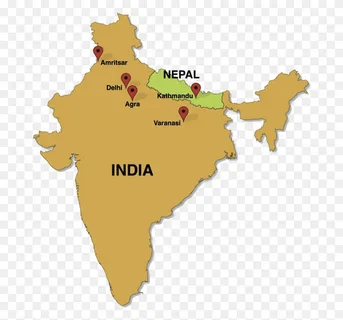

####Графики количества признаков

<Axes: title={'center': 'Число комнат/Количество'}, xlabel='Число комнат', ylabel='Количество'>

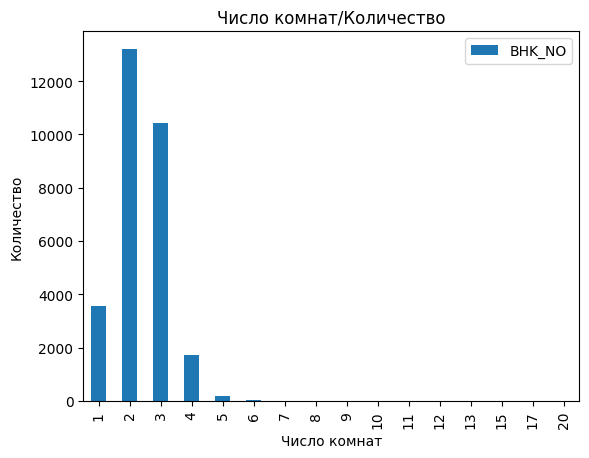

In [79]:
rooms = df_copy['BHK_NO'].value_counts().to_frame()
rooms.sort_index().plot(kind = 'bar', xlabel="Число комнат", ylabel="Количество", title = 'Число комнат/Количество')

<Axes: title={'center': 'POSTED_BY/Quantity'}, xlabel='POSTED_BY', ylabel='Quantity'>

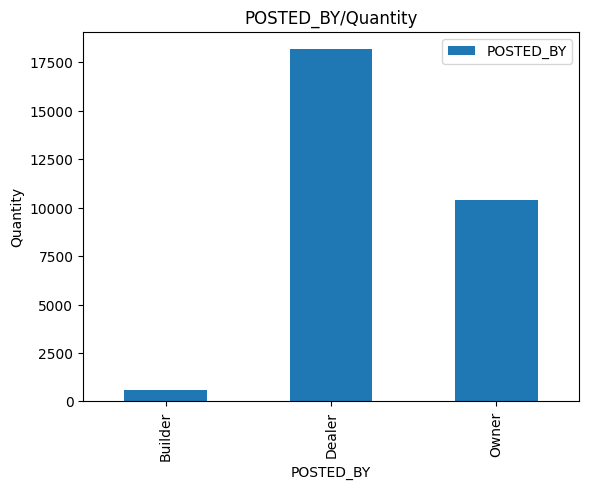

In [80]:
lacs = df['POSTED_BY'].value_counts().to_frame().sort_index()
lacs.plot(kind = 'bar', xlabel="POSTED_BY", ylabel="Quantity", title = 'POSTED_BY/Quantity')

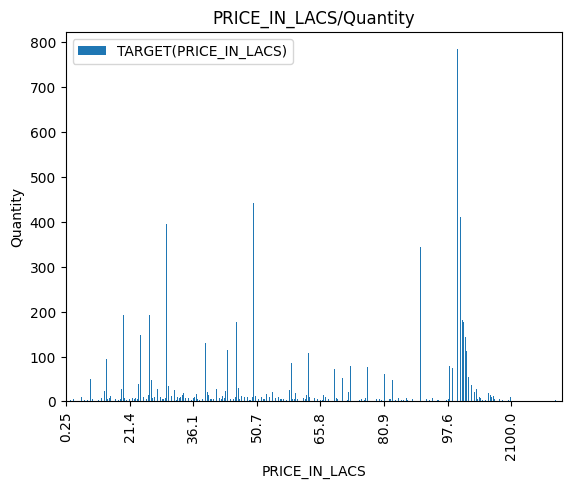

In [81]:
lacs = df_copy['TARGET(PRICE_IN_LACS)'].value_counts().to_frame().sort_index()

fig, ax = plt.subplots()
lacs.plot(kind = 'bar', xlabel="PRICE_IN_LACS", ylabel="Quantity", title = 'PRICE_IN_LACS/Quantity', ax=ax)
ticks = ax.get_xticks()
new_ticks = ticks[::150]
ax.set_xticks(new_ticks)

plt.show()

####Матрица корреляций

Не забудем удалить один столбец из POSTED_BY, ведь мы использовали OneHotEncoder

In [82]:
df_copy.shape

(29185, 12)

In [83]:
df_copy = df_copy.drop('POSTED_BY_Dealer', axis=1)

In [84]:
df_copy.shape

(29185, 11)

In [85]:
df_copy

,POSTED_BY_Owner,POSTED_BY_Builder,UNDER_CONSTRUCTION,RERA,BHK_NO,SQUARE_FT,READY_TO_MOVE,RESALE,LATITUDE,LONGITUDE,TARGET(PRICE_IN_LACS)
0,1.0,0.0,0,0,2,1300.236407,1,1,12.969910,77.597960,55.0
1,0.0,0.0,0,0,2,1275.000000,1,1,12.274538,76.644605,51.0
2,1.0,0.0,0,0,2,933.159722,1,1,12.778033,77.632191,43.0
3,1.0,0.0,0,1,2,929.921143,1,1,28.642300,77.344500,62.5
4,0.0,0.0,1,0,2,999.009247,0,1,22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...
29445,1.0,0.0,0,0,2,1062.134891,1,1,15.866670,74.500000,40.0
29446,1.0,0.0,0,0,3,2500.000000,1,1,27.140626,78.043277,45.0
29448,0.0,0.0,0,0,2,1022.641509,1,1,26.928785,75.828002,27.1
29449,1.0,0.0,0,0,2,927.079009,1,1,12.900150,80.227910,67.0


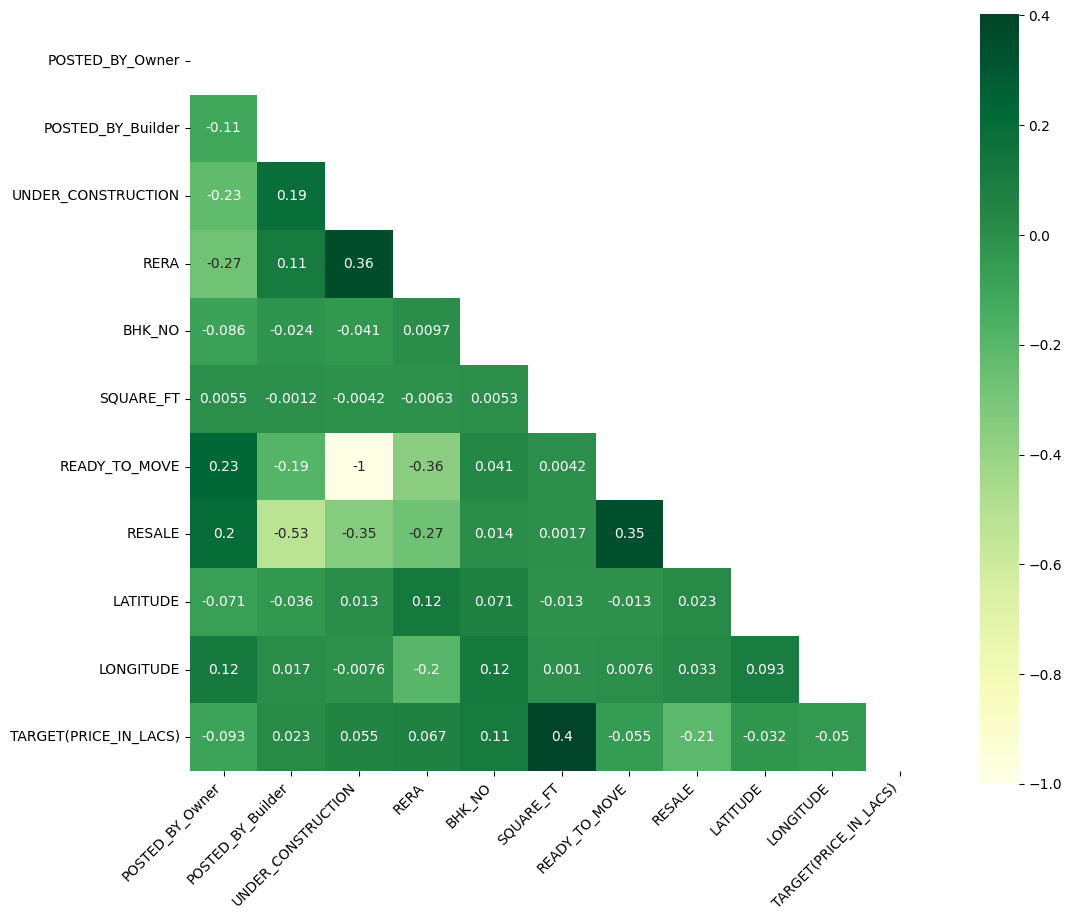

In [86]:
# Визуализируем корреляционную матрицу с помощью тепловой карты
mask = np.triu(df_copy.corr())
# Создаем полотно для отображения большого графика
f, ax = plt.subplots(figsize=(12, 10))
# Визуализируем данные кореляции и создаем цветовую политру
sns.heatmap(df_copy.corr(), mask = mask, annot = True, square = True, cmap = 'YlGn')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [87]:
#Удалим столбец READY_TO_MOVE ввиду его полной корреляции с UNDER_CONSTRUCTION
df_copy = df_copy.drop('READY_TO_MOVE', axis=1)

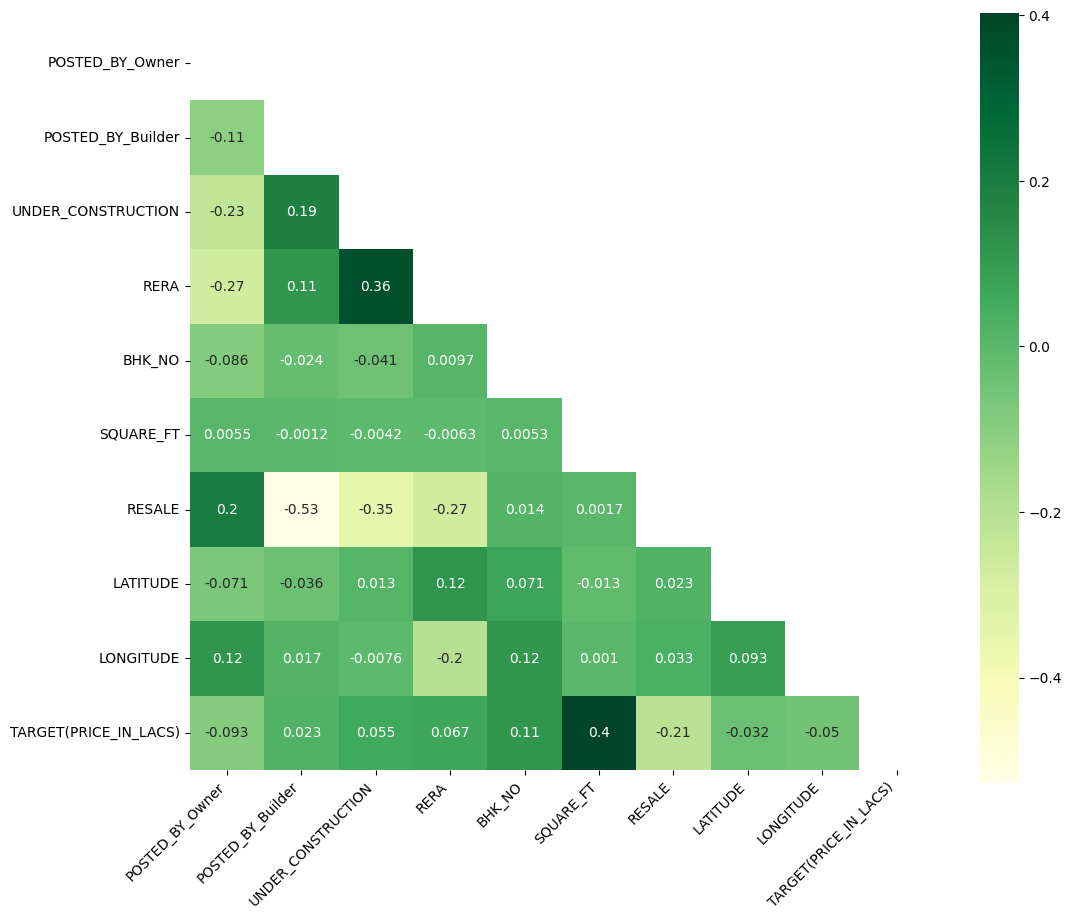

In [88]:
mask = np.triu(df_copy.corr())
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_copy.corr(), mask = mask, annot = True, square = True, cmap = 'YlGn')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

# Разделение и масштабирование выборки 

##Разделение датасета на две части

In [89]:
X = df_copy.drop('TARGET(PRICE_IN_LACS)', axis=1)
y = df_copy['TARGET(PRICE_IN_LACS)']

In [90]:
# Разделим датасет на три части
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## StandardScaler

Здесь мы масштабируем только столбцы BHK_NO, SQUARE_FT, LATITUDE, LONGITUDE, так как остальные бинарные. 

In [91]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [92]:
# Столбцы, которые надо отмасштабировать
cols_to_scale = ['BHK_NO','SQUARE_FT', 'LATITUDE', 'LONGITUDE']

In [93]:
# Копия для X_train
X_train_copy = X_train.copy()
sc.fit(X_train_copy[cols_to_scale])

# Масштабируем выбранные колонки
X_train_copy[cols_to_scale] = sc.transform(X_train_copy[cols_to_scale])
# Переводим в array
X_train_scaled = X_train_copy.to_numpy()

In [94]:
X_test_copy = X_test.copy()
X_test_copy[cols_to_scale] = sc.transform(X_test_copy[cols_to_scale])
X_test_scaled = X_test_copy.to_numpy()

# Постановка задачи

Получить наиболее точные предсказания на тестовой выборке. В качестве метрики для ML моделей был выбран R2, а для нейронных сетей MAE. В качестве функции потерь было взято RMSE.

Задача ML - максимизировать R2.

Задача нейронных сетей - минимизировать RMSE и максимизировать R2.

# Обучение на простых моделях

##Обучение простейшими моделями

In [ ]:
#Переводим pandas.Series в numpy для r2_score
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

##Линейная и dummy регрессия

###Dummy Regressor

In [ ]:
dummy_reg = DummyRegressor(strategy="median") 
scores = cross_val_score(dummy_reg, X_train_scaled, y_train, cv=10,  scoring='r2')
predictions = cross_val_predict(dummy_reg, X_train_scaled, y_train, cv=10)

In [ ]:
# Есть два варианта проверки точности обучения на тренировочных данных
# 1. Вывод средней точности суммы всех фолдов
print("Средняя точность по фолдам:", scores.mean())
#В этом случае мы получаем среднее значение R2 по всем фолдам

# 2. Возвращение для каждого элемента во входных данных прогноза, 
# который был получен для этого элемента, когда он находился в тестовом наборе 
# и расчёт на его основе R2.
print(f'r2_score train: {r2_score(y_train, predictions)}')

Средняя точность по фолдам: -0.017008692893244293
r2_score train: -0.015956710019153775


In [ ]:
dummy_reg.fit(X_train_scaled, y_train)
# Сделаем предсказание на обученой модели для тестовой выборки
preds = dummy_reg.predict(X_test_scaled)
# Получим результат R2 для tes
r2_score(y_test, preds)

-0.014221331454195463

###Линейная регрессия

In [ ]:
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=10, scoring='r2')
predictions = cross_val_predict(lin_reg, X_train, y_train, cv=10)

In [ ]:
# Есть два варианта проверки точности обучения на тренировочных данных
# 1. Вывод средней точности суммы всех фолдов
print("Средняя точность по фолдам:", scores.mean())
#В этом случае мы получаем среднее значение R2 по всем фолдам

# 2. Возвращение для каждого элемента во входных данных прогноза, 
# который был получен для этого элемента, когда он находился в тестовом наборе 
# и расчёт на его основе R2.
print(f'r2_score train: {r2_score(y_train, predictions)}')

Средняя точность по фолдам: -0.03523190848064781
r2_score train: -0.11274411503207715


In [ ]:
cross_val_lin_reg = pd.DataFrame(scores, columns=['R2 score for Linear regression']) 
cross_val_lin_reg = cross_val_lin_reg.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
cross_val_lin_reg.set_properties(**{'text-align': 'center'})

,R2 score for Linear regression
0,0.100623
1,0.011976
2,0.089016
3,0.359466
4,0.090733
5,0.102820
6,0.100202
7,-1.413141
8,0.103109
9,0.102876


In [ ]:
lin_reg.fit(X_train_scaled, y_train)
# Сделаем предсказание на обученой модели для тестовой выборки
preds = lin_reg.predict(X_test_scaled)
# Получим результат R2 для tes
r2_score(y_test, preds)

0.28081238144552223

###Полиномиальная регрессия

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Создание полиномиальных признаков
degree = 3 # Степень полинома
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_train_scaled)

LR = LinearRegression()
scores = cross_val_score(LR, X_poly, y_train, cv=5,  scoring='r2')

# Вывод средней точности
print("Средняя точность:", scores.mean())

# Обучение модели на всем обучающем наборе
LR.fit(X_poly, y_train)
predictions = cross_val_predict(LR, X_train_scaled, y_train, cv=5)
# Оценка точности на тестовом наборе
print(f'r2_score train: {r2_score(y_train, predictions)}')

Средняя точность: -31298602777.724316
r2_score train: -0.10916897300164252


##Простое усреднение

Используем несколько алгоритмов и возьмём среднее от их результатов




In [ ]:
models = [LinearRegression(), Ridge(), KNeighborsRegressor()]
preds = []
for model in models:
  model.fit(X_train_scaled, y_train)
  preds.append(model.predict(X_test_scaled))
y_preds = np.array(preds).mean(axis=0)
print(f'R2: {r2_score(y_test, y_preds)}')

R2: 0.3887625551841055


# Построение более сложных моделей

##RandomForest

####Вариант с выбором количества фолдов и случайно взятыми гиперпарамерами

In [ ]:
rf = RandomForestRegressor(n_estimators=20, random_state=2023)
scores = cross_val_score(rf, X_train_scaled, y_train, cv=10,  scoring='r2')
predictions = cross_val_predict(rf, X_train, y_train, cv=10)


# Есть два варианта проверки точности обучения на тренировочных данных
# 1. Вывод средней точности суммы всех фолдов
print("Средняя точность по фолдам:", scores.mean())
#В этом случае мы получаем среднее значение R2 по всем фолдам

# 2. Вывод R2 возвращает для каждого элемента во входных данных прогноз, 
# который был получен для этого элемента, когда он находился в тестовом наборе.
print(f'r2_score train: {r2_score(y_train, predictions)}')

Средняя точность по фолдам: 0.8587134810214397
r2_score train: 0.8444468019806266


In [ ]:
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=20, random_state=2023)

In [ ]:
# Сделаем предсказание на обученой модели для тестовой выборки
preds = rf.predict(X_test_scaled)

In [ ]:
# Получим результат R2 для tes
r2_score(y_test, preds)

0.9483869120886014

###Попробуем оптимизировать гиперпараметры

####Используем метод встроенной в optuna кросс-валидации OptunaSearchCV

In [ ]:
param_distrs = {'max_depth':optuna.distributions.IntDistribution(1, 10),
                'n_estimators':optuna.distributions.IntDistribution(5, 20)
}
rf = RandomForestRegressor(random_state=2023)

cv = 10
optuna_search = optuna.integration.OptunaSearchCV(rf, param_distrs, cv=cv, n_trials=50)
optuna_search.fit(X_train_scaled, y_train)

[I 2023-06-05 19:42:02,562] A new study created in memory with name: no-name-55ca28b9-9b48-4854-bf57-319574b50071
[I 2023-06-05 19:42:02,964] Trial 0 finished with value: 0.7232271197756728 and parameters: {'max_depth': 1, 'n_estimators': 5}. Best is trial 0 with value: 0.7232271197756728.
[I 2023-06-05 19:42:03,582] Trial 1 finished with value: 0.7692632037143609 and parameters: {'max_depth': 2, 'n_estimators': 5}. Best is trial 1 with value: 0.7692632037143609.
[I 2023-06-05 19:42:05,477] Trial 2 finished with value: 0.862234301164159 and parameters: {'max_depth': 5, 'n_estimators': 8}. Best is trial 2 with value: 0.862234301164159.
[I 2023-06-05 19:42:06,499] Trial 3 finished with value: 0.8443702905138302 and parameters: {'max_depth': 4, 'n_estimators': 5}. Best is trial 2 with value: 0.862234301164159.
[I 2023-06-05 19:42:10,980] Trial 4 finished with value: 0.8604746927735668 and parameters: {'max_depth': 10, 'n_estimators': 11}. Best is trial 2 with value: 0.862234301164159.
[I 

OptunaSearchCV(cv=10, estimator=RandomForestRegressor(random_state=2023),
               n_jobs=1, n_trials=50,
               param_distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=20, log=False, low=5, step=1)})

In [ ]:
print(optuna_search.best_params_)
print(optuna_search.best_score_)

{'max_depth': 8, 'n_estimators': 7}
0.8746183784779943


In [ ]:
RfOCV_bst_prms = optuna_search.best_params_
RfOCV_bst_prms

{'max_depth': 8, 'n_estimators': 7}

In [ ]:
rf = RandomForestRegressor(n_estimators=RfOCV_bst_prms['n_estimators'], 
                           max_depth=RfOCV_bst_prms['max_depth'], 
                           random_state=2023).fit(X_train_scaled, y_train)
scores = cross_val_score(rf, X_train_scaled, y_train, 
                         cv=cv, scoring='r2')
predictions = cross_val_predict(rf, X_train_scaled, y_train, cv=10)

In [ ]:
# Есть два варианта проверки точности обучения на тренировочных данных
# 1. Вывод средней точности суммы всех фолдов
print("Средняя точность по фолдам:", scores.mean())
#В этом случае мы получаем среднее значение R2 по всем фолдам

# 2. Вывод R2 возвращает для каждого элемента во входных данных прогноз, 
# который был получен для этого элемента, когда он находился в тестовом наборе.
print(f'r2_score train: {r2_score(y_train, predictions)}')

Средняя точность по фолдам: 0.8746183784779943
r2_score train: 0.8674928124475233


In [ ]:
# Сделаем предсказание на обученой модели для тестовой выборки
preds = rf.predict(X_test_scaled)

In [ ]:
# Получим результат R2 для tes
r2_score(y_test, preds)

0.9471981424304388

####Используем вариант с подбором количества фолдов

In [ ]:
def objective(trial):
  # выбираем количество деревьев
  max_depth = trial.suggest_int("max_depth", 5, 20, log=True) 
  # выбираем количество фолдов в кросс-валидации
  cv = trial.suggest_int("cv", 3, 10) 
  n_estimators = trial.suggest_int("n_estimators", 5, 20)
  

  classifier_obj = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=2023).fit(X_train_scaled, y_train)
  score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=cv)
  
  accuracy = score.mean()
  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50,show_progress_bar=True, n_jobs=-1, gc_after_trial=True)

[I 2023-06-05 16:36:12,008] A new study created in memory with name: no-name-ef9c6b37-dfd3-47c2-9506-0c79b4cba98a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-06-05 16:36:16,674] Trial 1 finished with value: 0.8776485119424596 and parameters: {'max_depth': 6, 'cv': 7, 'n_estimators': 9}. Best is trial 1 with value: 0.8776485119424596.
[I 2023-06-05 16:36:17,856] Trial 0 finished with value: 0.8765482735007839 and parameters: {'max_depth': 7, 'cv': 6, 'n_estimators': 14}. Best is trial 1 with value: 0.8776485119424596.
[I 2023-06-05 16:36:27,012] Trial 3 finished with value: 0.873271292761213 and parameters: {'max_depth': 17, 'cv': 4, 'n_estimators': 17}. Best is trial 1 with value: 0.8776485119424596.
[I 2023-06-05 16:36:31,453] Trial 2 finished with value: 0.858625665380156 and parameters: {'max_depth': 20, 'cv': 10, 'n_estimators': 11}. Best is trial 1 with value: 0.8776485119424596.
[I 2023-06-05 16:36:34,307] Trial 4 finished with value: 0.8639119183498281 and parameters: {'max_depth': 10, 'cv': 5, 'n_estimators': 15}. Best is trial 1 with value: 0.8776485119424596.
[I 2023-06-05 16:36:40,964] Trial 6 finished with value: 0.83744

In [ ]:
print(f'R^2 for RandomForest+Optuna (TEST): {study.best_value}\nBest parameters: {study.best_params}')

R^2 for RandomForest+Optuna (TEST): 0.8896907927813649
Best parameters: {'max_depth': 14, 'cv': 8, 'n_estimators': 7}


In [ ]:
RfO_bst_prms = study.best_params

In [ ]:
rf = RandomForestRegressor(n_estimators=RfO_bst_prms['n_estimators'], 
                           max_depth=RfO_bst_prms['max_depth'], 
                           random_state=2023).fit(X_train_scaled, y_train)
scores = cross_val_score(rf, X_train_scaled, y_train, 
                         cv=RfO_bst_prms['cv'], scoring='r2')
predictions = cross_val_predict(rf, X_train_scaled, y_train, cv=RfO_bst_prms['cv'])

In [ ]:
# Есть два варианта проверки точности обучения на тренировочных данных
# 1. Вывод средней точности суммы всех фолдов
print("Средняя точность по фолдам:", scores.mean())
#В этом случае мы получаем среднее значение R2 по всем фолдам

# 2. Вывод R2 возвращает для каждого элемента во входных данных прогноз, 
# который был получен для этого элемента, когда он находился в тестовом наборе.
print(f'r2_score для  выборки: {r2_score(y_train, predictions)}')

Средняя точность по фолдам: 0.8896907927813649
r2_score для  выборки: 0.8744655903853186


In [ ]:
predicts = rf.predict(X_test_scaled)

In [ ]:
r2_score(y_test, predicts)

0.9506207184961936

##XGBRegressor

###Стандартные гиперпараметры

In [ ]:
XGBR1 = XGBRegressor()

In [ ]:
scores = cross_val_score(XGBR1, X_train_scaled, y_train, scoring='r2', cv=10)
predictions = cross_val_predict(XGBR1, X_train_scaled, y_train, cv=5)

In [ ]:
predictions = cross_val_predict(XGBR1, X_train_scaled, y_train, cv=5)
print("Средняя точность по фолдам:", scores.mean())
print(f'R2 XGBR: {r2_score(y_train, predictions)}')

Средняя точность по фолдам: 0.8918894910063766
R2 XGBR: 0.8847790622299355


In [ ]:
XGBR1.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predicts = XGBR1.predict(X_test_scaled)

In [ ]:
r2_score(y_test, predicts)

0.9612333124841982

###Оптимизируем гиперпараметры

In [ ]:
def objective(trial):
  learning_rate = trial.suggest_float("learning_rate", 0.01, 1, step=0.2) 
  max_depth = trial.suggest_int("max_depth", 3, 10) 
  subsample = trial.suggest_float("subsample", 0.7, 1, step=0.05)
  colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1, step=0.1)
  n_estimators = trial.suggest_int("n_estimators", 50, 300, step=10)
  cv = trial.suggest_int("cv", 5, 20)

  XGBRO = XGBRegressor(learning_rate=learning_rate,
               max_depth=max_depth,
               subsample=subsample,
               colsample_bytree=colsample_bytree,
               n_estimators=n_estimators,
               cv=cv).fit(X_train_scaled, y_train)
               
  score = cross_val_score(XGBRO, X_train_scaled, y_train, n_jobs=-1, cv=cv, scoring='r2')
  
  accuracy = score.mean()
  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10,show_progress_bar=True, n_jobs=-1, gc_after_trial=True)

[I 2023-06-05 16:39:58,684] A new study created in memory with name: no-name-bb64c197-5a0d-4863-beb8-65717bbc568c


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-05 16:41:08,860] Trial 0 finished with value: 0.5686125477722715 and parameters: {'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.75, 'colsample_bytree': 0.8, 'n_estimators': 70, 'cv': 17}. Best is trial 0 with value: 0.5686125477722715.
[I 2023-06-05 16:41:52,120] Trial 1 finished with value: 0.8953439308591412 and parameters: {'learning_rate': 0.6100000000000001, 'max_depth': 10, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8, 'n_estimators': 240, 'cv': 14}. Best is trial 1 with value: 0.8953439308591412.
[I 2023-06-05 16:42:05,038] Trial 2 finished with value: 0.7621898201844788 and parameters: {'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.75, 'colsample_bytree': 0.9, 'n_estimators': 130, 'cv': 10}. Best is trial 1 with value: 0.8953439308591412.
[I 2023-06-05 16:42:45,244] Trial 4 finished with value: 0.8876169681718794 and parameters: {'learning_rate': 0.6100000000000001, 'max_depth': 5, 'subsample': 0.85, 'colsample_bytree': 0.8, 'n_estimators'

In [ ]:
print(f'R^2 for RandomForest+Optuna (TEST): {study.best_value}\nBest parameters: {study.best_params}')
st_bst_prms = study.best_params

R^2 for RandomForest+Optuna (TEST): 0.8984829841509144
Best parameters: {'learning_rate': 0.21000000000000002, 'max_depth': 5, 'subsample': 0.75, 'colsample_bytree': 0.9, 'n_estimators': 130, 'cv': 7}


In [ ]:
XGBR = XGBRegressor(learning_rate=st_bst_prms['learning_rate'],
               max_depth=st_bst_prms['max_depth'],
               subsample=st_bst_prms['subsample'],
               colsample_bytree=st_bst_prms['colsample_bytree'],
               n_estimators=st_bst_prms['n_estimators'])

scores = cross_val_score(rf, X_train_scaled, y_train, 
                         cv=st_bst_prms['cv'], scoring='r2')

In [ ]:
predictions = cross_val_predict(XGBR, X_test, y_test, cv=st_bst_prms['cv'])
# Вывод средней точности
print("Средняя точность по фолдам:", scores.mean())
print(f'r2_score train: {r2_score(y_test, predictions)}')

Средняя точность по фолдам: 0.8844835652939469
r2_score train: 0.8015644968576452


In [ ]:
XGBR.fit(X_train_scaled, y_train)
predicts = XGBR.predict(X_test_scaled)
r2_score(y_test, predicts)

0.9587054246016112

# Нейронные сети

Попробуем воспользоваться нейронными сетями для предсказания стоимости недвижимости. 

1.   Попробуем запустить простую нейросеть и посмотрим на результат
2.   Улучшим результат с помощью оптимизации гиперпараметров
3. Рассмотрим другие решения похожей архитектуры и посмотрим, какие результаты они могут показать



##Перцептрон

Попробуем выделить один слой в нейронной сети и собрать такого рода перцептрон:

In [111]:
from keras import backend as K
# Используем RMSE. Для этого нужно пропистать кастомную функцию
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [112]:
# Создадим слой
model = keras.Sequential([
    keras.layers.Dense(units=1, activation='linear', input_shape=(X_train_scaled.shape[1],))
])

# Скомпилируем модель
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

# Обучаем
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [113]:
# Предсказание
y_pred = model.predict(X_test_scaled)

301/301 [==============================] - 0s 1ms/step


In [114]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Text(0.5, 1.0, 'График потерь для RMSE')

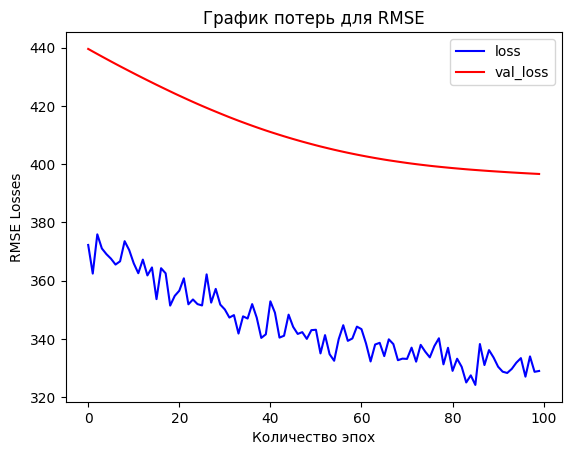

In [115]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['loss'], color='blue', label='loss')
plt.plot(num_epochs, history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("RMSE Losses")
plt.title('График потерь для RMSE')

Text(0.5, 1.0, 'График потерь для MAE')

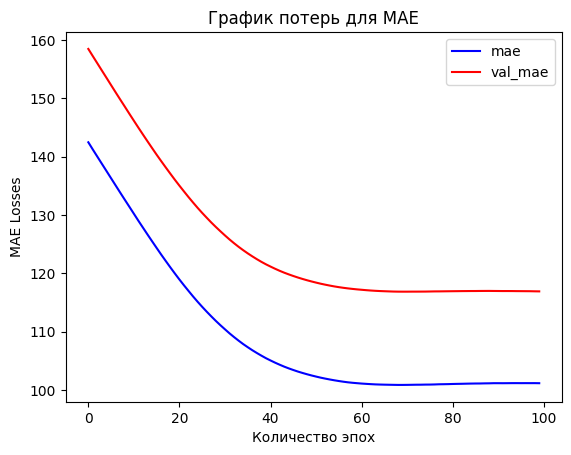

In [116]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['mae'], color='blue', label='mae')
plt.plot(num_epochs, history.history['val_mae'], color='red', label='val_mae')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("MAE Losses")
plt.title('График потерь для MAE')

In [118]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

r2 = r2_score(y_test, y_pred)
print("R^2 score:", r2)

MAE: 94.59486311358866
R^2 score: 0.004805917281429206


## Перцептрон с тремя слоями

In [126]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mae'])  

In [127]:
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=50, verbose=0)

In [128]:
predictions = model.predict(X_test_scaled)

301/301 [==============================] - 0s 1ms/step


In [129]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Text(0.5, 1.0, 'График потерь для RMSE')

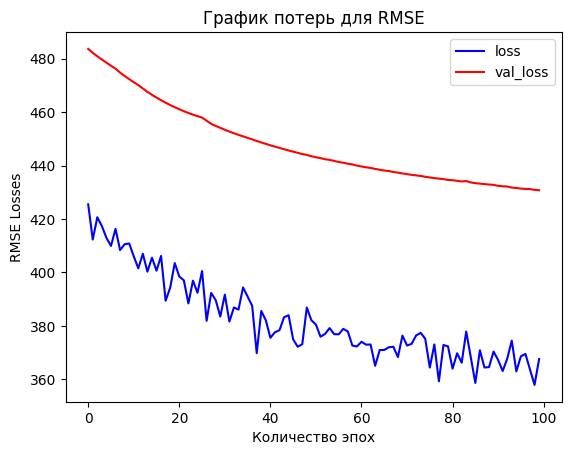

In [130]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['loss'], color='blue', label='loss')
plt.plot(num_epochs, history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("RMSE Losses")
plt.title('График потерь для RMSE')

Text(0.5, 1.0, 'График потерь для MAE')

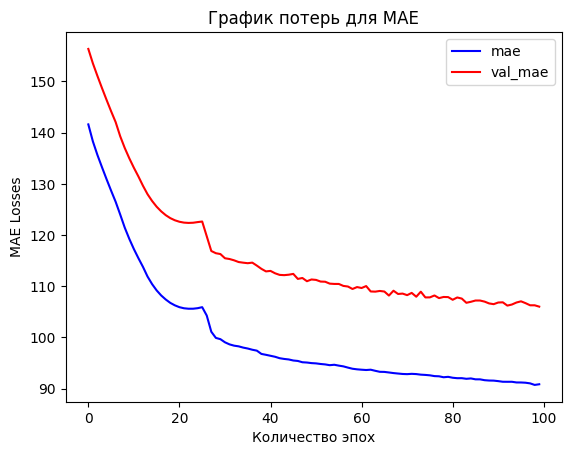

In [131]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['mae'], color='blue', label='mae')
plt.plot(num_epochs, history.history['val_mae'], color='red', label='val_mae')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("MAE Losses")
plt.title('График потерь для MAE')

In [132]:
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

r2 = r2_score(y_test, predictions)
print("R^2 score:", r2)

MAE: 83.90070008005415
R^2 score: 0.03213527856127929


Очень плохой результат. Судя по графикам потерь, модель недообучилась, значит можно её усложнять, увеличив количество нейронов и/или слоёв, изменив скорость обучения, а также попробовав использовать другие функции активации.

##Оптимизация гиперпараметров

###Grid search

Воспользуемся простейшим решетчатым поиском:

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
def build_model(hidden_units, learning_rate, activation):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dense(hidden_units, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mae'])
    return model

In [ ]:
model = KerasRegressor(build_fn=build_model, verbose=0)

param_grid = {
    'hidden_units': [32, 64, 128, 256],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'sigmoid','tanh']
}

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f94d108bf10>,
             param_grid={'activation': ['relu', 'sigmoid', 'tanh'],
                         'hidden_units': [32, 64, 128, 256],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [ ]:
best_hidden_units = grid_search.best_params_['hidden_units']
best_learning_rate = grid_search.best_params_['learning_rate']
best_activation = grid_search.best_params_['activation']

best_model = build_model(hidden_units=best_hidden_units, learning_rate=best_learning_rate, activation=best_activation)
history = best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=50, verbose=0, validation_split=0.2)

In [ ]:
predictions = best_model.predict(X_test_scaled)

301/301 [==============================] - 1s 3ms/step


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Text(0.5, 1.0, 'График потерь для RMSE')

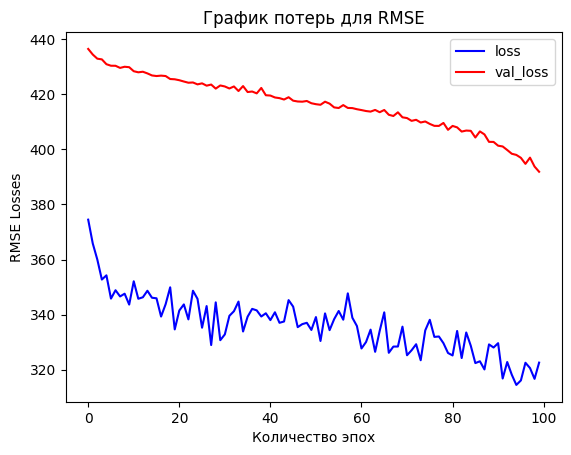

In [ ]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['loss'], color='blue', label='loss')
plt.plot(num_epochs, history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("RMSE Losses")
plt.title('График потерь для RMSE')

Text(0.5, 1.0, 'График потерь для MAE')

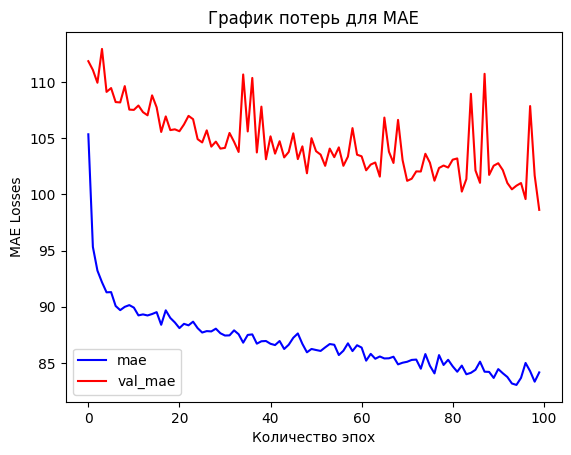

In [ ]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['mae'], color='blue', label='mae')
plt.plot(num_epochs, history.history['val_mae'], color='red', label='val_mae')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("MAE Losses")
plt.title('График потерь для MAE')

In [ ]:
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Best MAE:", mae)
print("Best R^2 score:", r2)

Best MAE: 75.91223289105938
Best R^2 score: 0.3395504134628736


Простой grid search добился значимого повышения R^2, но все же его значение не приблизилось к лучшим "алгоритмическим" решениям. Это позволяет нам предположить, что к хорошим результатам нам мешают прийти не столько неправильные гиперпараметры, сколько не самая подходящая архитектура.

## Пятислойная модель + оптимизация

Несмотря на вышесказанное, можно представить себе, что мы проанализировали недостаточно гиперпараметров. Чтобы проверить это, можем запустить алгоритм поиска наилучших гиперпараметров в большем пространстве:

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import optuna

def objective(trial):
    units_1 = trial.suggest_int('units_1', 32, 256, step=32)
    units_2 = trial.suggest_int('units_2', 32, 256, step=32)
    units_3 = trial.suggest_int('units_3', 32, 256, step=32)
    units_4 = trial.suggest_int('units_4', 32, 256, step=32)
    activation_1 = trial.suggest_categorical('activation_1', ['relu', 'tanh', 'sigmoid'])
    activation_2 = trial.suggest_categorical('activation_2', ['relu', 'tanh', 'sigmoid'])
    activation_3 = trial.suggest_categorical('activation_3', ['relu', 'tanh', 'sigmoid'])
    activation_4 = trial.suggest_categorical('activation_4', ['relu', 'tanh', 'sigmoid'])

    model = keras.Sequential()
    model.add(layers.Dense(units=units_1, activation=activation_1, input_shape=(X_train_scaled.shape[1],)))
    model.add(layers.Dense(units=units_2, activation=activation_2))
    model.add(layers.Dense(units=units_3, activation=activation_3))
    model.add(layers.Dense(units=units_4, activation=activation_4))
    model.add(layers.Dense(1))

    model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

    return loss

In [ ]:
# Define the Optuna study
study = optuna.create_study(direction='minimize')

# Run the hyperparameter optimization
study.optimize(objective, n_trials=10)

[I 2023-06-05 21:13:34,411] A new study created in memory with name: no-name-184bbcc6-56e2-42a1-9b3a-f79d00ce74b8


Epoch 1/10
489/489 [==============================] - 5s 9ms/step - loss: 333.5826 - mae: 101.0155 - val_loss: 385.4522 - val_mae: 114.1164
Epoch 2/10
489/489 [==============================] - 3s 6ms/step - loss: 319.0422 - mae: 94.9704 - val_loss: 386.1045 - val_mae: 118.8548
Epoch 3/10
489/489 [==============================] - 3s 6ms/step - loss: 309.4130 - mae: 93.3580 - val_loss: 377.5968 - val_mae: 107.5862
Epoch 4/10
489/489 [==============================] - 3s 6ms/step - loss: 306.3864 - mae: 92.5094 - val_loss: 374.6854 - val_mae: 107.3490
Epoch 5/10
489/489 [==============================] - 4s 7ms/step - loss: 299.5893 - mae: 92.3623 - val_loss: 372.9595 - val_mae: 108.1530
Epoch 6/10
489/489 [==============================] - 3s 7ms/step - loss: 310.1687 - mae: 91.6315 - val_loss: 369.7822 - val_mae: 104.4250
Epoch 7/10
489/489 [==============================] - 3s 6ms/step - loss: 306.4925 - mae: 91.3789 - val_loss: 366.1108 - val_mae: 107.8417
Epoch 8/10
489/489 [======

[I 2023-06-05 21:14:08,386] Trial 0 finished with value: 304.873291015625 and parameters: {'units_1': 192, 'units_2': 256, 'units_3': 160, 'units_4': 256, 'activation_1': 'tanh', 'activation_2': 'sigmoid', 'activation_3': 'tanh', 'activation_4': 'relu'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 4s 6ms/step - loss: 338.1129 - mae: 109.7444 - val_loss: 389.4556 - val_mae: 111.7360
Epoch 2/10
489/489 [==============================] - 3s 5ms/step - loss: 324.5824 - mae: 97.2479 - val_loss: 387.1417 - val_mae: 122.7748
Epoch 3/10
489/489 [==============================] - 3s 5ms/step - loss: 315.9608 - mae: 95.8937 - val_loss: 383.5827 - val_mae: 109.2224
Epoch 4/10
489/489 [==============================] - 4s 8ms/step - loss: 320.4283 - mae: 95.4286 - val_loss: 381.7790 - val_mae: 112.1463
Epoch 5/10
489/489 [==============================] - 3s 5ms/step - loss: 311.8373 - mae: 94.3813 - val_loss: 379.5746 - val_mae: 111.3132
Epoch 6/10
489/489 [==============================] - 3s 6ms/step - loss: 314.0255 - mae: 93.7400 - val_loss: 379.7238 - val_mae: 109.4699
Epoch 7/10
489/489 [==============================] - 3s 6ms/step - loss: 305.0014 - mae: 93.5833 - val_loss: 384.4897 - val_mae: 116.2103
Epoch 8/10
489/489 [======

[I 2023-06-05 21:14:39,471] Trial 1 finished with value: 304.873291015625 and parameters: {'units_1': 160, 'units_2': 128, 'units_3': 160, 'units_4': 224, 'activation_1': 'sigmoid', 'activation_2': 'sigmoid', 'activation_3': 'tanh', 'activation_4': 'relu'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 5s 7ms/step - loss: 349.7350 - mae: 108.9917 - val_loss: 404.3728 - val_mae: 116.0779
Epoch 2/10
489/489 [==============================] - 4s 9ms/step - loss: 334.1747 - mae: 98.1820 - val_loss: 395.9950 - val_mae: 114.3331
Epoch 3/10
489/489 [==============================] - 3s 7ms/step - loss: 329.5656 - mae: 96.2529 - val_loss: 390.8865 - val_mae: 111.8791
Epoch 4/10
489/489 [==============================] - 3s 7ms/step - loss: 323.8306 - mae: 94.5658 - val_loss: 388.5517 - val_mae: 108.6961
Epoch 5/10
489/489 [==============================] - 4s 7ms/step - loss: 325.9320 - mae: 93.2982 - val_loss: 385.1756 - val_mae: 107.5396
Epoch 6/10
489/489 [==============================] - 4s 9ms/step - loss: 312.2307 - mae: 91.5461 - val_loss: 383.2164 - val_mae: 106.0153
Epoch 7/10
489/489 [==============================] - 3s 6ms/step - loss: 322.3880 - mae: 90.8386 - val_loss: 384.1079 - val_mae: 108.1076
Epoch 8/10
489/489 [======

[I 2023-06-05 21:15:18,400] Trial 2 finished with value: 304.873291015625 and parameters: {'units_1': 224, 'units_2': 160, 'units_3': 256, 'units_4': 192, 'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_3': 'relu', 'activation_4': 'tanh'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 4s 5ms/step - loss: 342.3070 - mae: 107.1080 - val_loss: 388.2563 - val_mae: 108.4396
Epoch 2/10
489/489 [==============================] - 2s 4ms/step - loss: 318.6030 - mae: 93.3878 - val_loss: 381.9792 - val_mae: 106.5492
Epoch 3/10
489/489 [==============================] - 2s 4ms/step - loss: 316.5674 - mae: 91.6514 - val_loss: 379.2203 - val_mae: 109.4318
Epoch 4/10
489/489 [==============================] - 2s 4ms/step - loss: 310.5091 - mae: 90.0359 - val_loss: 374.5955 - val_mae: 104.8038
Epoch 5/10
489/489 [==============================] - 3s 5ms/step - loss: 303.7552 - mae: 89.1247 - val_loss: 372.5206 - val_mae: 103.2524
Epoch 6/10
489/489 [==============================] - 3s 5ms/step - loss: 297.9688 - mae: 88.1904 - val_loss: 362.3479 - val_mae: 102.1435
Epoch 7/10
489/489 [==============================] - 3s 5ms/step - loss: 294.1687 - mae: 86.3167 - val_loss: 356.7248 - val_mae: 107.5484
Epoch 8/10
489/489 [======

[I 2023-06-05 21:15:45,574] Trial 3 finished with value: 304.873291015625 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 160, 'units_4': 32, 'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'relu'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 4s 5ms/step - loss: 352.4360 - mae: 110.3810 - val_loss: 407.8189 - val_mae: 125.2520
Epoch 2/10
489/489 [==============================] - 2s 5ms/step - loss: 331.9837 - mae: 102.3500 - val_loss: 396.2955 - val_mae: 112.4943
Epoch 3/10
489/489 [==============================] - 2s 5ms/step - loss: 327.5366 - mae: 95.0486 - val_loss: 390.3030 - val_mae: 110.7771
Epoch 4/10
489/489 [==============================] - 2s 5ms/step - loss: 326.4652 - mae: 93.5629 - val_loss: 386.9331 - val_mae: 108.5431
Epoch 5/10
489/489 [==============================] - 3s 6ms/step - loss: 325.0400 - mae: 92.9106 - val_loss: 384.7786 - val_mae: 107.6324
Epoch 6/10
489/489 [==============================] - 3s 5ms/step - loss: 313.2687 - mae: 91.4661 - val_loss: 382.1045 - val_mae: 105.8681
Epoch 7/10
489/489 [==============================] - 2s 5ms/step - loss: 310.2554 - mae: 90.4749 - val_loss: 380.6350 - val_mae: 105.3342
Epoch 8/10
489/489 [=====

[I 2023-06-05 21:16:11,194] Trial 4 finished with value: 304.873291015625 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 96, 'units_4': 192, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'sigmoid', 'activation_4': 'tanh'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 5s 7ms/step - loss: 335.6299 - mae: 108.5881 - val_loss: 386.3094 - val_mae: 109.5703
Epoch 2/10
489/489 [==============================] - 2s 5ms/step - loss: 316.2554 - mae: 95.3194 - val_loss: 382.0812 - val_mae: 108.0443
Epoch 3/10
489/489 [==============================] - 2s 5ms/step - loss: 310.7430 - mae: 94.0840 - val_loss: 388.1832 - val_mae: 111.9852
Epoch 4/10
489/489 [==============================] - 2s 5ms/step - loss: 318.0943 - mae: 93.5099 - val_loss: 379.6169 - val_mae: 110.0909
Epoch 5/10
489/489 [==============================] - 3s 7ms/step - loss: 308.6127 - mae: 93.7275 - val_loss: 378.5357 - val_mae: 106.8963
Epoch 6/10
489/489 [==============================] - 3s 6ms/step - loss: 314.2790 - mae: 92.8288 - val_loss: 377.3517 - val_mae: 108.2364
Epoch 7/10
489/489 [==============================] - 2s 5ms/step - loss: 317.0779 - mae: 92.6913 - val_loss: 375.6003 - val_mae: 107.2292
Epoch 8/10
489/489 [======

[I 2023-06-05 21:16:54,111] Trial 5 finished with value: 304.873291015625 and parameters: {'units_1': 64, 'units_2': 224, 'units_3': 160, 'units_4': 224, 'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'relu'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 5s 8ms/step - loss: 358.7496 - mae: 128.7893 - val_loss: 427.9261 - val_mae: 138.4732
Epoch 2/10
489/489 [==============================] - 4s 8ms/step - loss: 359.8112 - mae: 116.4217 - val_loss: 420.9962 - val_mae: 128.7156
Epoch 3/10
489/489 [==============================] - 5s 11ms/step - loss: 353.4429 - mae: 109.0128 - val_loss: 415.6147 - val_mae: 123.7341
Epoch 4/10
489/489 [==============================] - 4s 9ms/step - loss: 343.8534 - mae: 105.9913 - val_loss: 411.8662 - val_mae: 122.3661
Epoch 5/10
489/489 [==============================] - 4s 8ms/step - loss: 340.3422 - mae: 105.8068 - val_loss: 409.5088 - val_mae: 122.9333
Epoch 6/10
489/489 [==============================] - 5s 10ms/step - loss: 334.7400 - mae: 106.9309 - val_loss: 408.2238 - val_mae: 124.3577
Epoch 7/10
489/489 [==============================] - 4s 8ms/step - loss: 337.8295 - mae: 108.5861 - val_loss: 407.6101 - val_mae: 125.9221
Epoch 8/10
489/489

[I 2023-06-05 21:17:38,902] Trial 6 finished with value: 304.873291015625 and parameters: {'units_1': 224, 'units_2': 256, 'units_3': 256, 'units_4': 32, 'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'tanh', 'activation_4': 'tanh'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 4s 5ms/step - loss: 340.0871 - mae: 110.8680 - val_loss: 408.6246 - val_mae: 123.7491
Epoch 2/10
489/489 [==============================] - 2s 5ms/step - loss: 343.5701 - mae: 110.1019 - val_loss: 407.2334 - val_mae: 128.5283
Epoch 3/10
489/489 [==============================] - 3s 7ms/step - loss: 342.2920 - mae: 112.2600 - val_loss: 407.2105 - val_mae: 129.4589
Epoch 4/10
489/489 [==============================] - 3s 5ms/step - loss: 343.3871 - mae: 112.3210 - val_loss: 407.2159 - val_mae: 129.9262
Epoch 5/10
489/489 [==============================] - 2s 5ms/step - loss: 326.3154 - mae: 103.4121 - val_loss: 397.1029 - val_mae: 112.7724
Epoch 6/10
489/489 [==============================] - 2s 5ms/step - loss: 328.8072 - mae: 96.6366 - val_loss: 392.7410 - val_mae: 111.8985
Epoch 7/10
489/489 [==============================] - 2s 5ms/step - loss: 323.8513 - mae: 96.0621 - val_loss: 389.8745 - val_mae: 110.6373
Epoch 8/10
489/489 [==

[I 2023-06-05 21:18:06,944] Trial 7 finished with value: 304.873291015625 and parameters: {'units_1': 192, 'units_2': 160, 'units_3': 64, 'units_4': 160, 'activation_1': 'sigmoid', 'activation_2': 'relu', 'activation_3': 'tanh', 'activation_4': 'tanh'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 5s 8ms/step - loss: 326.9032 - mae: 99.1147 - val_loss: 380.5693 - val_mae: 107.7805
Epoch 2/10
489/489 [==============================] - 5s 10ms/step - loss: 310.8878 - mae: 91.9546 - val_loss: 379.4042 - val_mae: 106.6474
Epoch 3/10
489/489 [==============================] - 4s 8ms/step - loss: 317.9145 - mae: 91.1597 - val_loss: 375.7188 - val_mae: 111.4964
Epoch 4/10
489/489 [==============================] - 4s 7ms/step - loss: 303.2193 - mae: 89.4602 - val_loss: 370.6315 - val_mae: 105.6368
Epoch 5/10
489/489 [==============================] - 4s 9ms/step - loss: 300.2052 - mae: 88.6601 - val_loss: 369.5376 - val_mae: 103.4094
Epoch 6/10
489/489 [==============================] - 4s 8ms/step - loss: 311.2909 - mae: 87.9124 - val_loss: 366.5755 - val_mae: 101.4787
Epoch 7/10
489/489 [==============================] - 3s 7ms/step - loss: 303.4214 - mae: 87.3263 - val_loss: 360.9911 - val_mae: 99.8954
Epoch 8/10
489/489 [=======

[I 2023-06-05 21:18:48,541] Trial 8 finished with value: 304.873291015625 and parameters: {'units_1': 192, 'units_2': 256, 'units_3': 224, 'units_4': 256, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'tanh', 'activation_4': 'relu'}. Best is trial 0 with value: 304.873291015625.


Epoch 1/10
489/489 [==============================] - 4s 6ms/step - loss: 328.6253 - mae: 102.9622 - val_loss: 387.4082 - val_mae: 109.1533
Epoch 2/10
489/489 [==============================] - 3s 6ms/step - loss: 318.9869 - mae: 94.6726 - val_loss: 383.0569 - val_mae: 111.0090
Epoch 3/10
489/489 [==============================] - 4s 9ms/step - loss: 313.5995 - mae: 92.4978 - val_loss: 379.7123 - val_mae: 107.2301
Epoch 4/10
489/489 [==============================] - 3s 6ms/step - loss: 309.3893 - mae: 91.4418 - val_loss: 379.6930 - val_mae: 109.4019
Epoch 5/10
489/489 [==============================] - 2s 5ms/step - loss: 308.5728 - mae: 90.4198 - val_loss: 374.4737 - val_mae: 107.1065
Epoch 6/10
489/489 [==============================] - 2s 5ms/step - loss: 303.4629 - mae: 89.2557 - val_loss: 372.9526 - val_mae: 106.2371
Epoch 7/10
489/489 [==============================] - 3s 7ms/step - loss: 303.9679 - mae: 88.9378 - val_loss: 369.3848 - val_mae: 106.2003
Epoch 8/10
489/489 [======

[I 2023-06-05 21:19:30,767] Trial 9 finished with value: 304.873291015625 and parameters: {'units_1': 224, 'units_2': 256, 'units_3': 64, 'units_4': 96, 'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_3': 'tanh', 'activation_4': 'relu'}. Best is trial 0 with value: 304.873291015625.


In [ ]:
best_params = study.best_params

model = keras.Sequential()
model.add(layers.Dense(units=best_params['units_1'], activation=best_params['activation_1'], input_shape=(X_train.shape[1],)))
model.add(layers.Dense(units=best_params['units_2'], activation=best_params['activation_2']))
model.add(layers.Dense(units=best_params['units_3'], activation=best_params['activation_3']))
model.add(layers.Dense(units=best_params['units_4'], activation=best_params['activation_4']))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0)

In [ ]:
y_pred = model.predict(X_test_scaled)

301/301 [==============================] - 1s 2ms/step


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Text(0.5, 1.0, 'График потерь для RMSE')

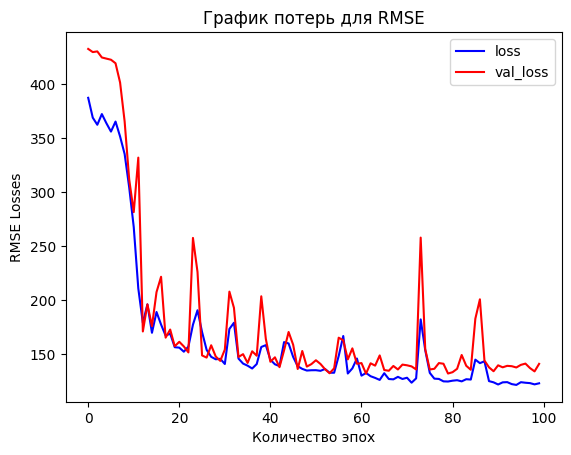

In [ ]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['loss'], color='blue', label='loss')
plt.plot(num_epochs, history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("RMSE Losses")
plt.title('График потерь для RMSE')

Text(0.5, 1.0, 'График потерь для MAE')

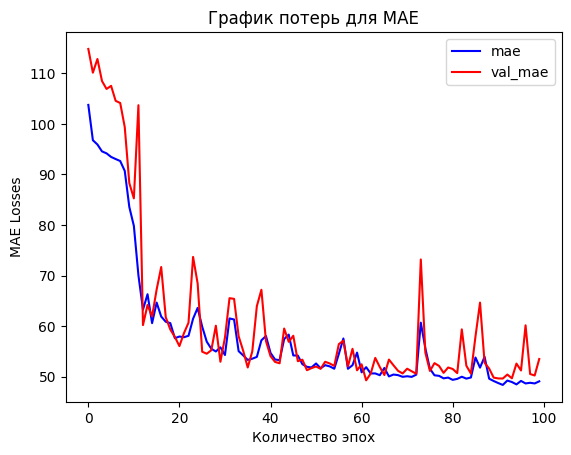

In [ ]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['mae'], color='blue', label='mae')
plt.plot(num_epochs, history.history['val_mae'], color='red', label='val_mae')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("MAE Losses")
plt.title('График потерь для MAE')

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best MAE:", mae)
print("Best R^2 score:", r2)

Best MAE: 51.951102596359
Best R^2 score: 0.8251887733197164


##Шестислойная модель

In [105]:
# Перцептрон с 6 слоями
model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mae'])

In [106]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [107]:
y_pred = model.predict(X_test_scaled)

301/301 [==============================] - 1s 3ms/step


Text(0.5, 1.0, 'График потерь для RMSE')

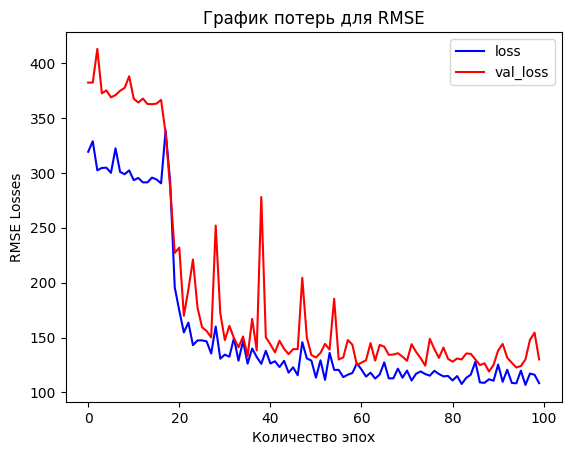

In [108]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['loss'], color='blue', label='loss')
plt.plot(num_epochs, history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("RMSE Losses")
plt.title('График потерь для RMSE')

Text(0.5, 1.0, 'График потерь для MAE')

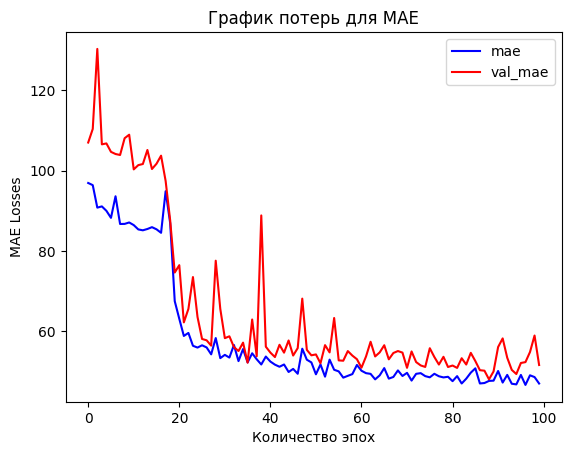

In [109]:
num_epochs = np.arange(100)
plt.plot(num_epochs, history.history['mae'], color='blue', label='mae')
plt.plot(num_epochs, history.history['val_mae'], color='red', label='val_mae')
plt.legend(loc='best')
plt.xlabel("Количество эпох")
plt.ylabel("MAE Losses")
plt.title('График потерь для MAE')

In [110]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best MAE:", mae)
print("Best R^2 score:", r2)

Best MAE: 47.305512288727634
Best R^2 score: 0.9313038066760414
